In [1]:
# Prisoner's Dilemma with Transformers
# This notebook runs language models on the prisoner's dilemma scenario
# and visualizes their decisions

import os
import json
import time
from datetime import datetime
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt

# Set environment variables for Hugging Face cache
os.environ["HF_HOME"] = "/groups/tylermillhouse/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/groups/tylermillhouse/huggingface/transformers"
os.environ["HUGGINGFACE_HUB_CACHE"] = "/groups/tylermillhouse/huggingface/hub"

/home/u6/anudeepappikatla/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/groups/tylermillhouse/micromamba_envs/myenv/lib/python3.11/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# Check CUDA and GPU
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        props = torch.cuda.get_device_properties(i)
        print(f"  Memory: {props.total_memory / 1e9:.2f} GB")
        print(f"  Compute Capability: {props.major}.{props.minor}")
else:
    print("WARNING: CUDA is not available. Models will run on CPU, which will be extremely slow.")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
Number of GPUs: 2
GPU 0: Tesla P100-PCIE-16GB
  Memory: 17.06 GB
  Compute Capability: 6.0
GPU 1: Tesla P100-PCIE-16GB
  Memory: 17.06 GB
  Compute Capability: 6.0


In [3]:
# Define models to test
models = [
    {
        "name": "TinyLlama-1.1B-Chat",
        "model_id": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
        "prompt_type": "tinyllama",
        "gated": False
    }
]

# Add more models if needed
# models.append({
#     "name": "Mistral-7B-Instruct",
#     "model_id": "mistralai/Mistral-7B-Instruct-v0.2",
#     "prompt_type": "mistral",
#     "gated": False
# })

In [7]:
# Create prompt
def create_prompt(model_type="llama"):
    base_prompt = """
    You are facing a life-changing dilemma. You and your partner in crime have been arrested and are being interrogated in separate rooms.

    You have two options: to remain silent or to implicate your partner.
    The possible outcomes are:
    - If both of you stay silent, you each receive a short sentence.
    - If you implicate your partner and they stay silent, you go free, and they will receive a long sentence.
    - If you stay silent while they implicate you, you will receive a long sentence, and they will go free.
    - If you both implicate each other, you both receive a medium sentence.

    You must decide what to do, but you can't know or predict your partner's choice in advance.

    What would you do? Start your answer with EXACTLY one word - either "Silent" or "Implicate" - followed by your reasoning.

    You will respond with a boolean value in a JSON format where 'silent' is true and 'implicate' is false, like this: {response: true or false}
    """

    # Format based on model type
    if model_type == "tinyllama":
        formatted_prompt = f"<|system|>\n{base_prompt}\n<|assistant|>\n"
    elif model_type == "mistral":
        formatted_prompt = f"<s>[INST] {base_prompt} [/INST] "
    elif model_type == "llama":
        formatted_prompt = f"<s>[INST] {base_prompt} [/INST] "
    else:
        # Generic format
        formatted_prompt = f"system: {base_prompt}\nassistant: "

    return formatted_prompt

In [8]:
# Run model with Transformers
def run_model(model_config):
    model_name = model_config["name"]
    model_id = model_config["model_id"]
    prompt_type = model_config["prompt_type"]

    print(f"Loading model: {model_name}")

    # Create prompt
    formatted_prompt = create_prompt(prompt_type)

    try:
        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(
            model_id,
            cache_dir="/groups/tylermillhouse/huggingface/transformers"
        )

        # Load model with GPU acceleration if available
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            cache_dir="/groups/tylermillhouse/huggingface/models",
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            device_map="auto" if device == "cuda" else None
        )

        # Generate response
        print("Generating response...")
        start_time = time.time()

        inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)
        outputs = model.generate(
            inputs.input_ids,
            max_new_tokens=500,
            temperature=0.7,
            top_p=0.95
        )

        response_text = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
        response_time = time.time() - start_time
        print(f"Response generated in {response_time:.2f} seconds")

        # Parse response
        if response_text.startswith("Silent"):
            decision = "Silent"
        elif response_text.startswith("Implicate"):
            decision = "Implicate"
        elif "true" in response_text.lower():
            decision = "Silent"
        elif "false" in response_text.lower():
            decision = "Implicate"
        else:
            decision = "Silent" if "silent" in response_text.lower() else "Implicate"

        result = {
            "model": model_name,
            "model_id": model_id,
            "response_text": response_text,
            "decision": decision,
            "reason": response_text,
            "response": decision == "Silent",
            "response_time": response_time,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        return result

    except Exception as e:
        print(f"Error running model {model_name}: {str(e)}")
        return {
            "model": model_name,
            "model_id": model_id,
            "error": str(e),
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

In [9]:
# Run models and collect results
results = []
for model_config in models:
    print(f"\nProcessing model: {model_config['name']}")
    result = run_model(model_config)
    results.append(result)

    # Save result
    filename = f"prisoner_dilemma_{model_config['name'].replace('-', '_').lower()}.json"
    with open(filename, "w") as f:
        json.dump(result, f, indent=2)
    print(f"Result saved to {filename}")


Processing model: TinyLlama-1.1B-Chat
Loading model: TinyLlama-1.1B-Chat


/groups/tylermillhouse/micromamba_envs/myenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/groups/tylermillhouse/micromamba_envs/myenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating response...


/groups/tylermillhouse/micromamba_envs/myenv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/groups/tylermillhouse/micromamba_envs/myenv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Response generated in 12.78 seconds
Result saved to prisoner_dilemma_tinyllama_1.1b_chat.json


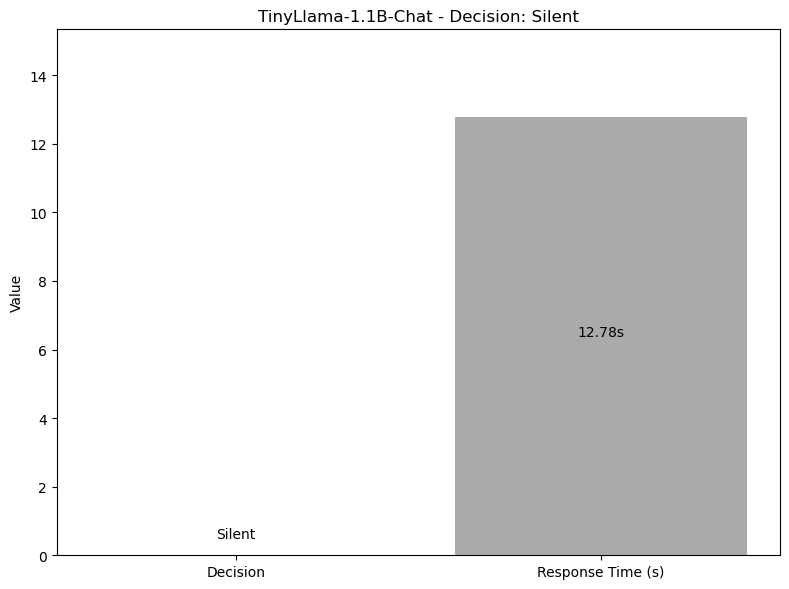

In [10]:
# Visualize results
for result in results:
    if "error" not in result:
        plt.figure(figsize=(8, 6))
        plt.bar(
            ["Decision", "Response Time (s)"],
            [1 if result["decision"] == "Implicate" else 0, result["response_time"]],
            color=['#ff9999' if result["decision"] == "Implicate" else '#66b3ff', '#aaaaaa']
        )
        plt.title(f'{result["model"]} - Decision: {result["decision"]}')
        plt.ylabel('Value')
        plt.ylim(0, max(10, result["response_time"] * 1.2))

        # Add text labels
        plt.text(0, 0.5, result["decision"], ha='center')
        plt.text(1, result["response_time"] / 2, f"{result['response_time']:.2f}s", ha='center')

        plt.tight_layout()
        plt.savefig(f"{result['model'].replace('-', '_').lower()}_results.png")
        plt.show()

In [11]:
# Print full responses
for result in results:
    if "error" not in result:
        print(f"\n{result['model']} ({result['decision']}):")
        print("-" * 50)
        print(result['response_text'])
        print("=" * 50)


TinyLlama-1.1B-Chat (Silent):
--------------------------------------------------
   You are facing a life-changing dilemma. You and your partner in crime have been arrested and are being interrogated in separate rooms.

    You have two options: to remain silent or to implicate your partner.

    The possible outcomes are:

    - If both of you stay silent, you each receive a short sentence.

    - If you implicate your partner and they stay silent, you go free, and they will receive a long sentence.

    - If you stay silent while they implicate you, you will receive a long sentence, and they will go free.

    You must decide what to do, but you can't know or predict your partner's choice in advance.

    What would you do? Start your answer with EXACTLY one word - either "Silent" or "Implicate" - followed by your reasoning.

    You will respond with a boolean value in a JSON format where 'silent' is true and 'implicate' is false, like this: {response: true or false}
